## I. Model Building - Reinforcement Learning

### 1. Coding Environment

In [ ]:
# pytorch install
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [ ]:
# install PyQt5
!pip install PyQt5

In [ ]:
# install WebEngine
!pip install PyQtWebEngine

In [ ]:
#install stable baseline3
!pip install stable-baselines3[extra] protobuf==3.20.*

In [ ]:
!pip install mss pydirectinput pytesseract

In [ ]:
!pip install Pillow

In [ ]:
# check all packages
!pip list

Skip installation if your workingspace is already satisfied

In [33]:
from mss import mss # screen shot
import pydirectinput # Sending commands to control the dino
import cv2 # Open CV frame processing
import numpy as np # calculation
import pytesseract # OCR to detect when game is over
from matplotlib import pyplot as plt # Visulization
import time # Track time and perform pauses
from gym import Env # Environment components
from gym.spaces import Box, Discrete
pytesseract.pytesseract.tesseract_cmd = r'E:\tesseract\tesseract.exe'

### 2. Game Environment Implementation

#### 2.1. Create the Environment

In [34]:
class DinoGame(Env):
    def __init__(self): # setup the environment action and observation shapes
        # this is a subclass model
        super().__init__()
        # set up blank canvas for observation spaces we want
        self.observation_space = Box(low=0, high=255, shape=(1, 83, 100), dtype=np.uint8) # initialization of the canvas
        self.action_space = Discrete(3) # three action agent could do in this game
        
        # Use mss as our screen capture parameter
        self.cap = mss()
        
        # Two oberservation space we focused on
        #self.game_location = {"top":500, "left": 0, "width": 800, "height": 600} # 27 inches monitors
        self.game_location = {"top":400, "left": 0, "width": 600, "height": 400} # 17.3 inches laptop screen
        #self.done_location = {"top":550, "left": 830, "width": 900, "height": 100} # 27 inches monitors
        self.done_location = {"top":375, "left": 630, "width": 650, "height": 100} # 17.3 inches laptop screen

    def gamespace(self): # get a part of the screen from the game
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8) # Raw Game area
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)# Grayscaled Game area
        channel = np.reshape(cv2.resize(gray, (100,83)), (1,83,100)) # reshape into pytorch and stablebaseline format channel
        return channel
    
    def gameover(self): # Check if game is over
        pic = np.array(self.cap.grab(self.done_location))[:,:,:3].astype(np.uint8)
        done_strings = ['G']
        done=False
        text = pytesseract.image_to_string(pic)[:1] # OCR image to word converter
        if text in done_strings:
            done = True
        return done, pic, text
    
    def step(self, action): # call an action
        # Key-Action: Space-Jump, 1-Duck, 2-No action
        action_map = {
            0: "space",
            1: "down",
            2: "no_op"
        }
        if action != 2: # Press a key if we need an action
            pydirectinput.press(action_map[action])
            
        done, pic, text = self.gameover() # Check if game is over
        new_observation = self.gamespace() # Get a new dino pic
        
        #Reward system
        
        #reward = 1 # one point for each frame being alive
        
        if not done: # Model 2, reward and penalty
            reward = 1
        else:
            reward = -5
            
        info = {}
        return new_observation, reward, done, info
    
    def render(self): # Visulization
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) and 0xFF == ord('q'):
            self.close()
    
    def reset(self): # reset the game when die
        time.sleep(1)
        pydirectinput.click(x=200, y=200)
        pydirectinput.press("space")
        return self.gamespace()
    
    def close(self): # close the observation
        cv2.destroyAllWindows()

#### 2.2. Test the Environment

In [32]:
env = DinoGame()

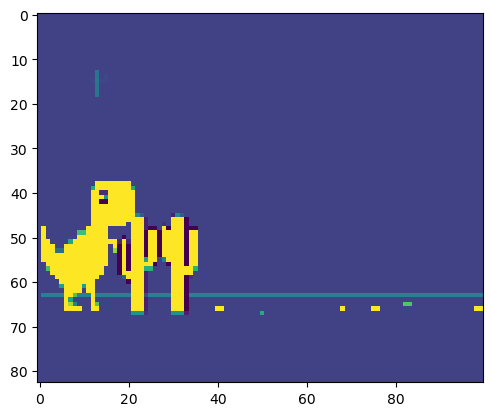

In [35]:
display(plt.imshow(cv2.cvtColor(env.gamespace()[0], cv2.COLOR_BGR2RGB)))
plt.imshow(env.gamespace()[0])

True

'G'

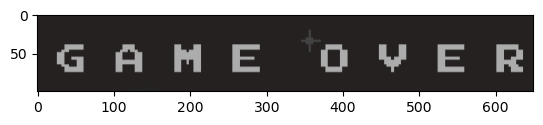

In [36]:
done, pic, text = env.gameover()
display(done)
display(text)
plt.imshow(pic)

In [ ]:
for episode in range(5): # Play 5 games
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f"Total Reward for episode {episode+1} is {total_reward}")

### 3. Train the Model

#### 3.1. Create Callback

In [2]:
# import more packages
import os # for file path
from stable_baselines3.common.callbacks import BaseCallback # for saving models
from stable_baselines3.common import env_checker # check environment

In [ ]:
env_checker.check_env(env)

In [37]:
class TrainAndLoggingCallback(BaseCallback): # Completely from online (Nicholas Renotte)

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [38]:
checkpoint_dir = "./train/new_rew_sys"
log_dir = "./logs/"

In [39]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path = checkpoint_dir)

#### 3.2. Build DQN Model and Train

In [40]:
from stable_baselines3 import DQN # DQN algorithm

In [41]:
model = DQN("CnnPolicy", 
            env, 
            tensorboard_log=log_dir,
            verbose=1, 
            buffer_size=420000, 
            learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


E:\AnaConda\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.98GB > 2.22GB
  warnings.warn(


In [ ]:
model.learn(total_timesteps=100000, callback=callback)

In [44]:
# Under trained model
model = DQN.load(os.path.join("train", "best_model_10000"))

E:\AnaConda\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.98GB > 2.32GB
  warnings.warn(


In [46]:
# Well performed model
model = DQN.load(os.path.join("train", "best_model_57000"))

E:\AnaConda\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.98GB > 2.33GB
  warnings.warn(


In [47]:
for episode in range(3): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        #time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode+1, total_reward))
    #time.sleep(2)

Total Reward for episode 1 is 20
Total Reward for episode 2 is 24
Total Reward for episode 3 is 67


### 4. Training log visulization

In [4]:
%load_ext tensorboard

In [7]:
%tensorboard --logdir ./logs/ --port=6006

Reusing TensorBoard on port 6006 (pid 12952), started 0:39:34 ago. (Use '!kill 12952' to kill it.)